<a href="https://colab.research.google.com/github/Ajay-2007/deep-reinforcement-learning-projects/blob/master/technical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from utils import *

import time
import numpy as np

# from mxnet import nd, autograd, gluon
# from mxnet.gluon import nn, rnn
# import maxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/bo_test/test_data'

/content/drive/My Drive/Colab Notebooks/bo_test/test_data


In [ ]:
cd major

/content/drive/My Drive/Colab Notebooks/bo_test/test_data/major


In [ ]:
ls

 AUDUSD3Min_cleaned.csv   GBPUSD3Min_cleaned.csv  'USDCAD .csv'
'AUDUSD .csv'            'GBPUSD .csv'             USDCHF3Min_cleaned.csv
 dask-worker-space/       NZDUSD3Min_cleaned.csv  'USDCHF .csv'
 EURUSD3Min_cleaned.csv  'NZDUSD .csv'             USDJPY3Min_cleaned.csv
'EURUSD .csv'             USDCAD3Min_cleaned.csv  'USDJPY .csv'


In [ ]:
def parser(x):
  return datetime.datetime.strptime(x, "%Y-%m-%d")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("USDJPY3Min_cleaned.csv", header=0, parse_dates=[0])

In [ ]:
df.head()

,date,open,high,low,close,volume
0,2003-05-06 00:02:00,117.537,117.539,117.496,117.522,783399986.0
1,2003-05-06 00:05:00,117.528,117.528,117.505,117.505,252999997.0
2,2003-05-06 00:08:00,117.513,117.513,117.465,117.467,410300005.0
3,2003-05-06 00:11:00,117.517,117.530,117.499,117.499,540700004.0
4,2003-05-06 00:14:00,117.489,117.606,117.488,117.606,373000001.0


In [ ]:
df.tail()

,date,open,high,low,close,volume
887293,2020-06-19 09:47:00,106.928,106.928,106.924,106.927,32490000.0
887294,2020-06-19 09:50:00,106.851,106.851,106.835,106.837,117190000.0
887295,2020-06-19 09:53:00,106.844,106.844,106.844,106.844,10800000.0
887296,2020-06-19 09:56:00,106.827,106.831,106.821,106.824,81770000.0
887297,2020-06-19 09:59:00,106.813,106.813,106.801,106.802,115010000.0


In [ ]:
df.shape

(887298, 6)

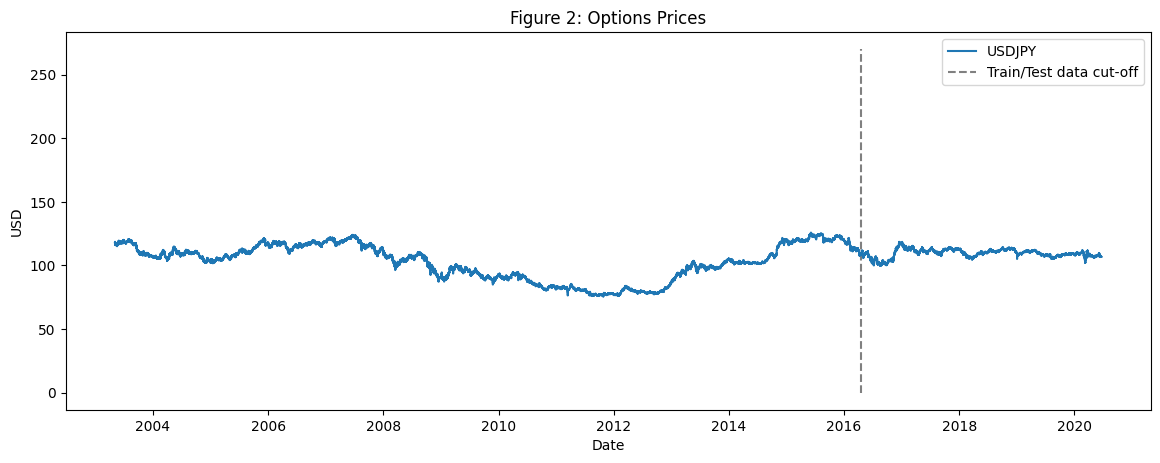

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['date'], df['close'], label='USDJPY')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Options Prices')
plt.legend()
plt.show()

In [ ]:
num_training_timestamp = int(df.shape[0]*.7)
print('Number of training timestamp: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    df.shape[0]-num_training_timestamp))

Number of training timestamp: 621108. Number of test days: 266190.


# Technical Analysis

In [ ]:
df['close']

0         117.522
1         117.505
2         117.467
3         117.499
4         117.606
           ...   
887293    106.927
887294    106.837
887295    106.844
887296    106.824
887297    106.802
Name: close, Length: 887298, dtype: float64

In [ ]:
x = df.copy(deep=True)

In [ ]:
x['new'] = pd.DataFrame(df['close']).rolling(5).std()

In [ ]:
df['close'].rolling(5).std()

0              NaN
1              NaN
2              NaN
3              NaN
4         0.052141
            ...   
887293    0.033246
887294    0.036596
887295    0.037663
887296    0.040960
887297    0.047599
Name: close, Length: 887298, dtype: float64

In [ ]:
def get_technical_indicators(dataset):
  # create 7 and 21 minutes Moving Average
  dataset['ma7'] = dataset['close'].rolling(window=7).mean()
  dataset['ma21'] = dataset['close'].rolling(window=21).mean()

  # Moving Average Convergence Divergence (MACD) is a trend-following momentum 
  # indicator that shows the relationship between two moving averages of a 
  # security's price. The MACD is calculated by subtracting the 26-period 
  # Exponential Moving Average (EMA) from the 12-period EMA.

  dataset['26ema'] = dataset['close'].ewm(span=26).mean()
  dataset['12ema'] = dataset['close'].ewm(span=12).mean()
  # dataset['12ema'] = pd.DataFrame.ewma(dataset['close'], span=12)
  dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

  # Create Bollinger Bands
  # A Bollinger Band® is a technical analysis tool defined by a set of trendlines
  # plotted two standard deviations (positively and negatively) away from a 
  # simple moving average (SMA) of a security's price, but which can be adjusted
  # to user preferences.

  dataset['20sd'] = dataset['close'].rolling(20).std()
  dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
  dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

  # Create Exponential moving average
  # An exponential moving average (EMA) is a type of moving average (MA) that 
  # places a greater weight and significance on the most recent data points. 
  # The exponential moving average is also referred to as the exponentially 
  # weighted moving average.
  dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

  # Create Momentum
  # Momentum trading is a technique in which traders buy and sell according to 
  # the strength of recent price trends. Momentum traders bet that an asset 
  # price that is moving strongly in a given direction will continue to move in
  # that direction until the trend loses strength.
  dataset['momentum'] = dataset['close']-1
  dataset['log_momentum'] = np.log(dataset['close']) 
  
  return dataset
  


In [ ]:
dataset_TI_df = get_technical_indicators(df[['close']])

In [ ]:
dataset_ti_df = dataset_TI_df.copy(deep=True)

In [ ]:
dataset_ti_df.set_index(df.date)

,close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
date,,,,,,,,,,,,
2003-05-06 00:02:00,117.522,NaN,NaN,117.522000,117.522000,0.000000,NaN,NaN,NaN,117.522000,116.522,4.766626
2003-05-06 00:05:00,117.505,NaN,NaN,117.513173,117.512792,-0.000381,NaN,NaN,NaN,117.509250,116.505,4.766481
2003-05-06 00:08:00,117.467,NaN,NaN,117.496584,117.494919,-0.001664,NaN,NaN,NaN,117.480000,116.467,4.766157
2003-05-06 00:11:00,117.499,NaN,NaN,117.497259,117.496207,-0.001052,NaN,NaN,NaN,117.492825,116.499,4.766430
2003-05-06 00:14:00,117.606,NaN,NaN,117.522477,117.526038,0.003561,NaN,NaN,NaN,117.568587,116.606,4.767340
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-19 09:47:00,106.927,106.871571,106.870905,106.871904,106.874559,0.002656,0.019040,106.908984,106.832825,106.900533,105.927,4.672146
2020-06-19 09:50:00,106.837,106.866857,106.869619,106.869318,106.868781,-0.000537,0.020374,106.910366,106.828872,106.858178,105.837,4.671304
2020-06-19 09:53:00,106.844,106.862714,106.868905,106.867443,106.864968,-0.002474,0.020899,106.910703,106.827107,106.848726,105.844,4.671370


In [ ]:
dataset_TI_df.head()

,close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,117.522,NaN,NaN,117.522000,117.522000,0.000000,NaN,NaN,NaN,117.522000,116.522,4.766626
1,117.505,NaN,NaN,117.513173,117.512792,-0.000381,NaN,NaN,NaN,117.509250,116.505,4.766481
2,117.467,NaN,NaN,117.496584,117.494919,-0.001664,NaN,NaN,NaN,117.480000,116.467,4.766157
3,117.499,NaN,NaN,117.497259,117.496207,-0.001052,NaN,NaN,NaN,117.492825,116.499,4.766430
4,117.606,NaN,NaN,117.522477,117.526038,0.003561,NaN,NaN,NaN,117.568587,116.606,4.767340


In [ ]:
def plot_technical_indicators(dataset, last_timestamp):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_timestamp
    
    dataset = dataset.iloc[-last_timestamp:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for USDJPY - last {} timestamp.'.format(last_timestamp))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

In [ ]:
df.shape

(887298, 6)

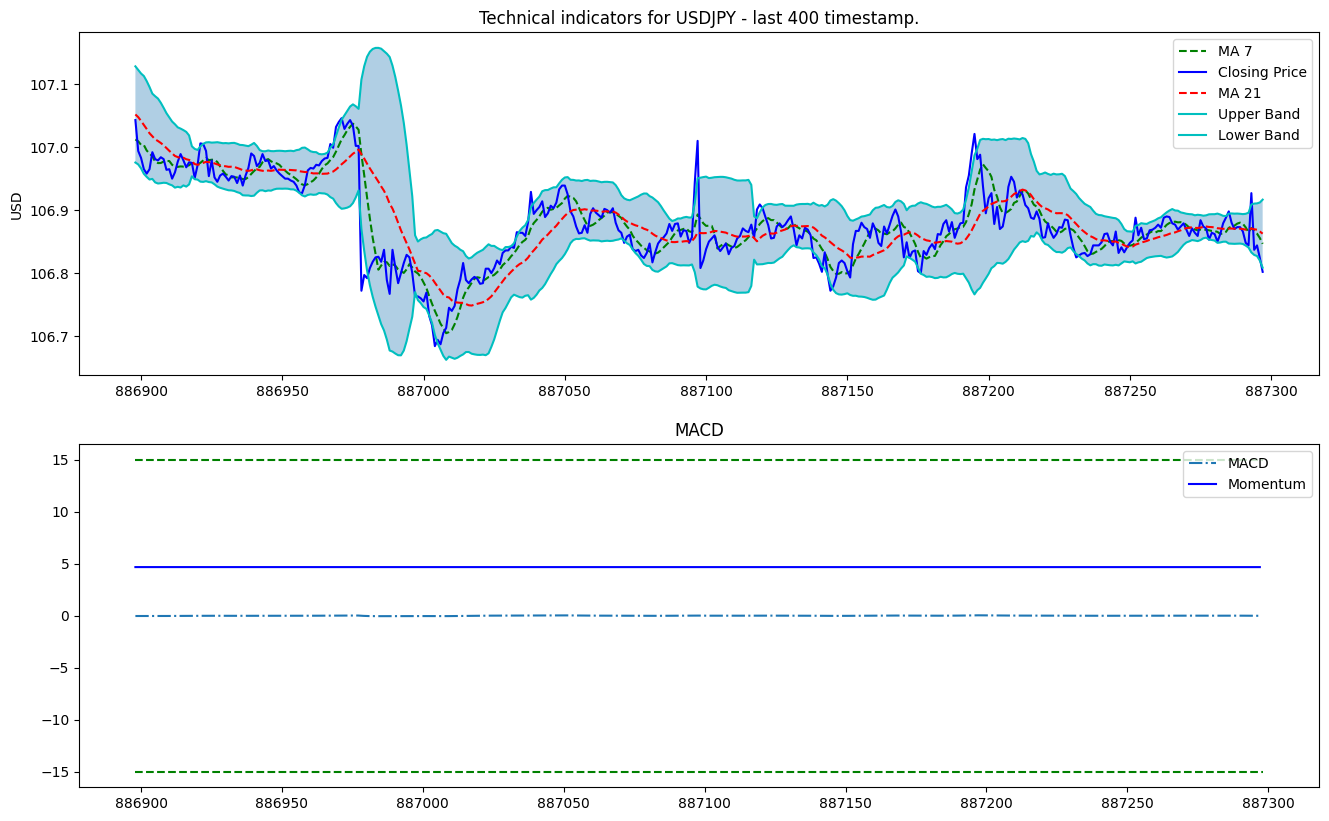

In [ ]:
plot_technical_indicators(dataset_ti_df, 400)

# Fundamental Analysis

* For fundamental analysis we will perform sentiment analysis on all daily news about Forex Market of each currency pair. 
* For each day we will create a average daily score ( as a number between 0 and 1) and add it as a feature. 

In [ ]:
import bert

# Fourier Transforms for trend analysis

* Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames).
* When combined, these sine waves approximate the original function.
* Mathematically speaking, the transforms look like this: 

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

* We will use Fourier transforms to extract global and local trends in closing 
prices, and also denoise it a little.

In [ ]:
data_ft = df[['date', 'close']]

In [ ]:
close_fft = np.fft.fft(np.asarray(data_ft['close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

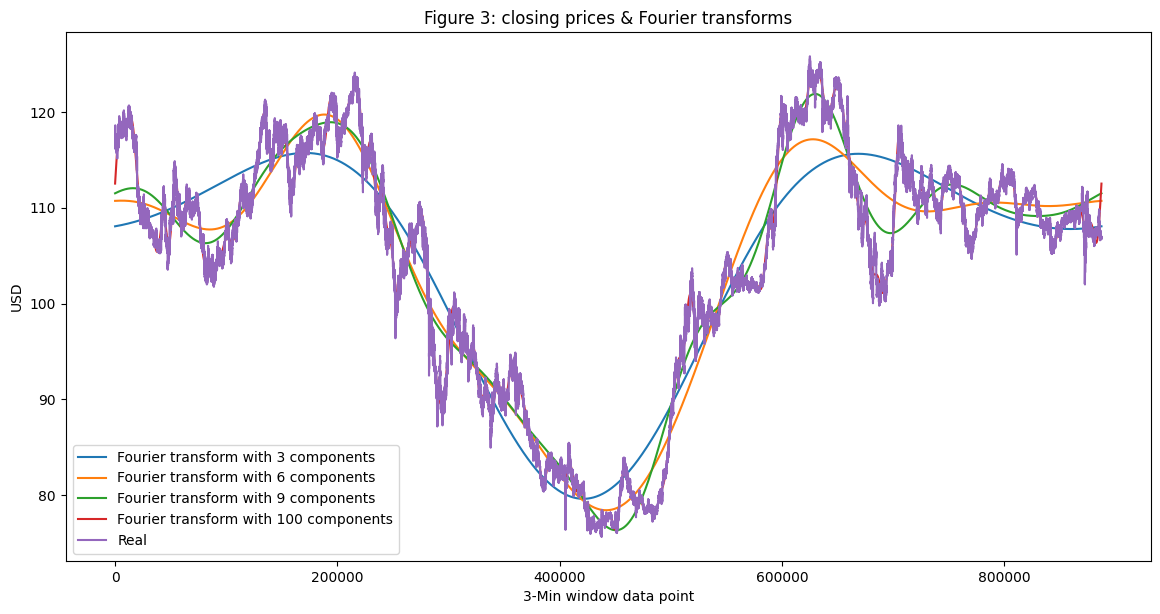

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_ft['close'],  label='Real')
plt.xlabel('3-Min window data point')
plt.ylabel('USD')
plt.title('Figure 3: closing prices & Fourier transforms')
plt.legend()
plt.show()

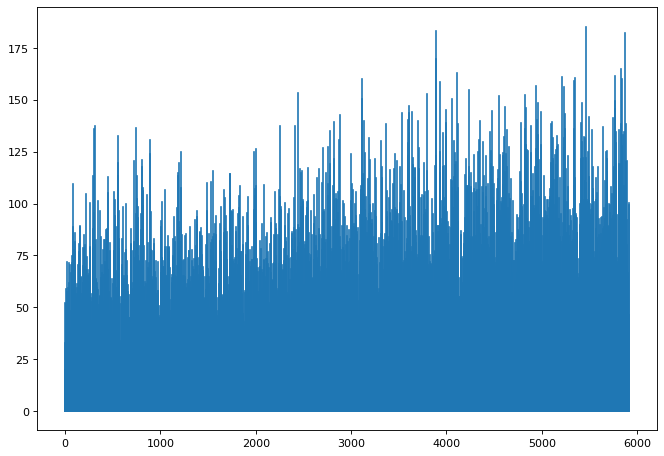

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'][:100000].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_ft['close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                99999
Model:                 ARIMA(5, 1, 0)   Log Likelihood               59781.882
Method:                       css-mle   S.D. of innovations              0.133
Date:                Fri, 26 Jun 2020   AIC                        -119549.764
Time:                        20:14:30   BIC                        -119483.174
Sample:                             1   HQIC                       -119529.555
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.341e-05      0.000     -0.416      0.677      -0.001       0.000
ar.L1.D.close    -0.3766      0.003   -119.245      0.000      -0.383      -0.370
ar.L2.D.close    -0.1951      0.003    -

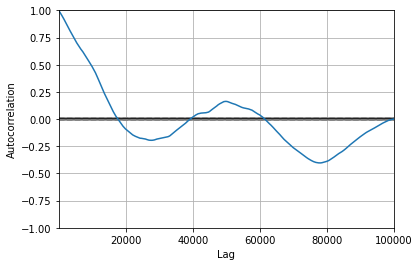

<Figure size 800x560 with 0 Axes>

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

# Feature Selection

In [ ]:
def get_feature_importance_data(data):
    data = data.copy()
    y = data['close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
dataset_ti_df.isna().sum()

close            0
ma7              6
ma21            20
26ema            0
12ema            0
MACD             0
20sd            19
upper_band      20
lower_band      20
ema              0
momentum         0
log_momentum     0
dtype: int64

In [ ]:
dataset_ti_df_test  = dataset_ti_df.copy(deep=True)

In [ ]:
dataset_ti_df_test.dropna(inplace=True)

In [ ]:
dataset_ti_df_test.head()

,close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,117.482,117.540857,117.528762,117.530186,117.528571,-0.001614,0.035547,117.599855,117.457668,117.492916,116.482,4.766285
21,117.502,117.532429,117.527810,117.527627,117.524377,-0.003250,0.035660,117.599129,117.456490,117.498972,116.502,4.766455
22,117.497,117.520857,117.527429,117.524893,117.520073,-0.004820,0.033481,117.594391,117.460466,117.497657,116.497,4.766413
23,117.502,117.511857,117.529095,117.522880,117.517241,-0.005638,0.033339,117.595774,117.462416,117.500552,116.502,4.766455
24,117.482,117.499714,117.528286,117.519334,117.511735,-0.007599,0.029936,117.588157,117.468414,117.488184,116.482,4.766285


In [ ]:
dataset_ti_df_test.shape

(887278, 12)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(dataset_ti_df_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
dataset_ti_df_test_minmax = scaler.transform(dataset_ti_df_test)

In [ ]:
dataset_ti_df_test.columns

Index(['close', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [ ]:
dataset_ti_df_test_minmax =pd.DataFrame(dataset_ti_df_test_minmax, columns=['close', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'])

In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_ti_df_test_minmax)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[21:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

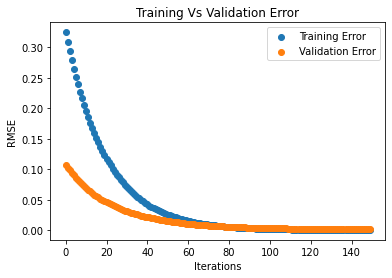

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

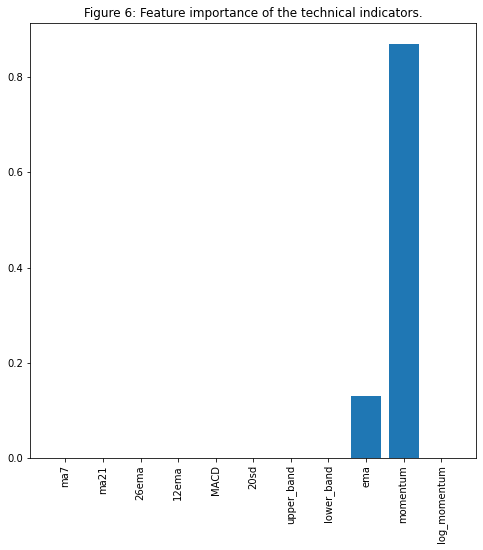

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

# Extracting High Level Features with Stacked Autoencoders

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

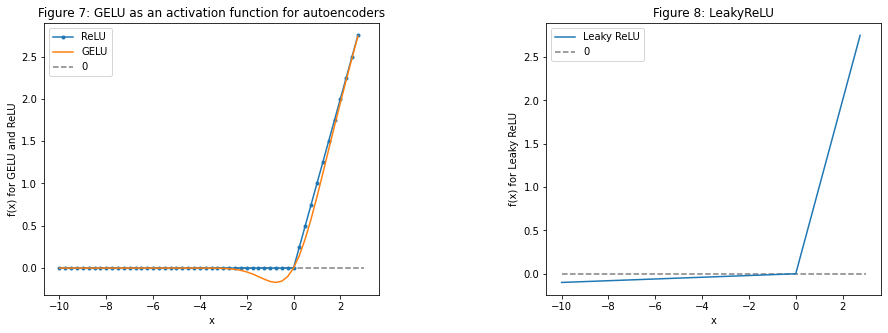

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()